/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['a', 'b', 'c', 'd'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['e', 'f', 'g', 'h'])


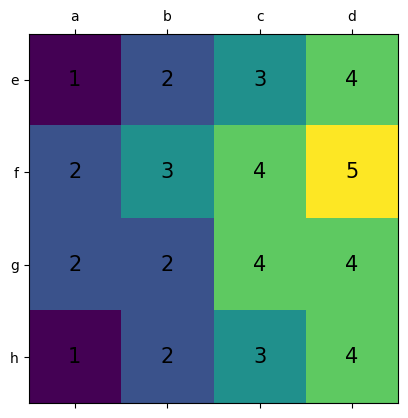

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['insert', 'fairness', 'notions', 'here'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:206: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No Missing', 'MCAR', 'MAR', 'NMAR'])


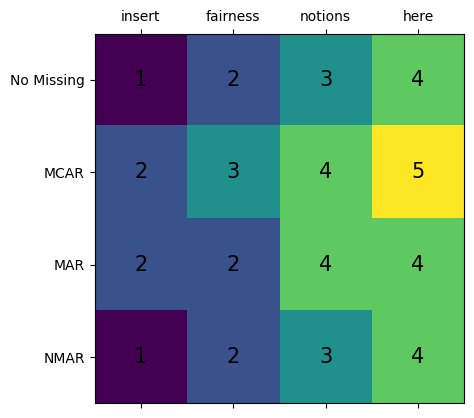

pip install 'aif360[LawSchoolGPA]'


In [1]:
import os
import sys
from src.cleaning import datacleaning
from src import data_generation
from src.preparation import model_perform
import pandas as pd
import numpy as np
import aif360
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import average_odds_difference
from aif360.sklearn.metrics import equal_opportunity_difference

In [2]:
data = datacleaning.cleaning(os.path.join(os.path.dirname(
    os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [3]:
target = sys.argv[1]

if target == "test":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/test.csv'))

if target == "all":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [4]:
data.isna().sum()

complainant_age_incident    0
allegation                  0
contact_reason              0
substantiated               0
complainant_gender          0
dtype: int64

In [5]:
data.head()

,complainant_age_incident,allegation,contact_reason,substantiated,complainant_gender
0,38.0,Failure to provide RTKA card,Report-domestic dispute,True,Female
1,26.0,Action,Moving violation,True,Male
2,26.0,Race,Moving violation,True,Male
3,45.0,Question,PD suspected C/V of violation/crime - street,True,Male
5,31.0,Refusal to process civilian complaint,C/V telephoned PCT,True,Male


In [6]:
train, test = train_test_split(data, train_size=0.8)

## Missingness Creation

We want the attribute with missingness to have around the same proportion of missingness for each type. This is because we don't want the amount of missingness to be a confounding factor in our results.

In [7]:
t = train.copy()
mcar = data_generation.mcar(t, 'complainant_gender')

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [8]:
mcar['complainant_gender'].isna().sum() / mcar.shape[0]

0.19851773425092642

In [10]:
mcar = mcar.dropna(subset = 'complainant_gender')

For MAR, we want to try to find attributes that are, ideally, highly correlated with both the sensitive attribute and the label outcome attribute. Let's first look into the complainant age attribute.

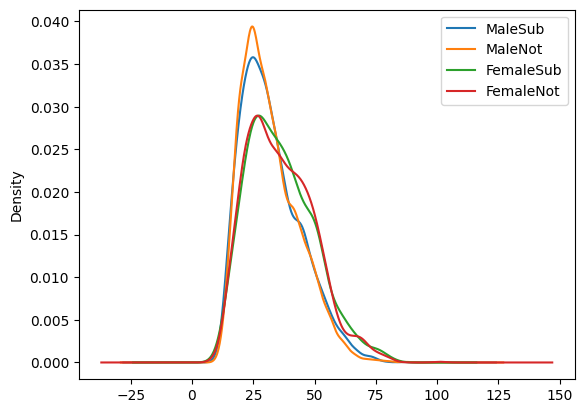

In [11]:
for gender in ['Male', 'Female']:
    for sub in [True, False]:
        data[(data['complainant_gender'] == gender) & (
            data['substantiated'] == sub)]['complainant_age_incident'].plot(kind='density', legend=True)
    plt.legend(['MaleSub', 'MaleNot', 'FemaleSub', 'FemaleNot'])

It looks like complainant age is only highly correlated with the sensitive attribute, and not the outcome label. This will still work with the goal we have in mind, though. 

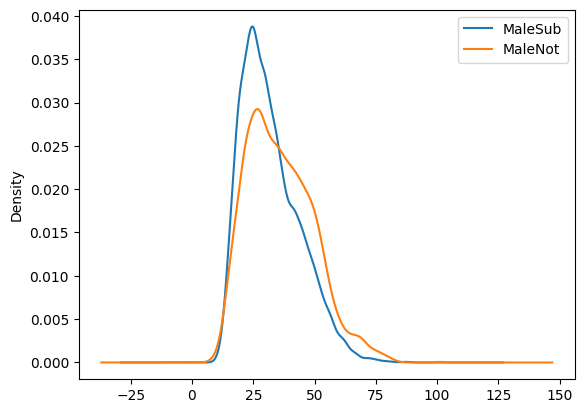

In [12]:
for gender in ['Male', 'Female']:
    data[(data['complainant_gender'] == gender)]['complainant_age_incident'].plot(kind='density', legend=True)
plt.legend(['MaleSub', 'MaleNot', 'FemaleSub', 'FemaleNot'])

In order to add to the noticeability of MAR (where each category of our sensitive attribute has a different amount of missinness) we will only apply MAR missingness to the underprivileged group (females). Non-MAR missingness can be added to the privileged group to see how different types of missingness produce differences among the sensitive attribute.

In [13]:
t = train.copy()
male = data_generation.mcar(t[t['complainant_gender'] == 'Male'], 'complainant_gender')
female = data_generation.mar(t[t['complainant_gender'] == 'Female'], 'complainant_gender', 'substantiated', 0.2)
for idx, i in enumerate(female.iterrows()):
    # if S = 0 & Y = 1, add additional probability of missingness
    if (i[1]['substantiated'] == True) and (i[1]['complainant_gender'] == 'Female'):
        if np.random.choice([1, 0], p = [0.3, 0.7]) == 1:
            female['complainant_gender'].iloc[idx] = np.nan
mar = pd.concat([male, female])
mar

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


{False: 0.25613288122776195, True: 0.5110610594407673}


/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[miss_column].iloc[i] = np.nan
/var/folders/c2/wd6pf3ls7732c5mp_5vvb1cw0000gn/T/ipykernel_3969/3012774097.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female['complainant_gender'].iloc[idx] = np.nan


,complainant_age_incident,allegation,contact_reason,substantiated,complainant_gender
10539,43.0,Animal,PD suspected C/V of violation/crime - bldg,False,Male
4518,63.0,Forcible Removal to Hospital,Aided case,False,Male
22291,47.0,Threat to damage/seize property,PD suspected C/V of violation/crime - auto,False,Male
14575,15.0,Hit against inanimate object,PD suspected C/V of violation/crime - street,False,NaN
24298,42.0,Threat to damage/seize property,Other violation of VTL,False,Male
...,...,...,...,...,...
25527,36.0,Refusal to provide name/shield number,C/V intervened on behalf of/observed encounter...,False,Female
2423,58.0,Physical force,Other,False,Female
4478,46.0,Threat of arrest,C/V telephoned PCT,False,Female
21483,15.0,Stop,PD suspected C/V of violation/crime - street,False,Female


In [14]:
#mar = data_generation.mar(t, 'substantiated', 'complainant_gender', 0.3)

In [15]:
mar['complainant_gender'].isna().sum() / mar.shape[0]

0.18790343973826157

In [17]:
mar = mar.dropna(subset = 'complainant_gender')

In [18]:
t = train.copy()
nmar = data_generation.nmar(t, 'complainant_gender', 0.3)

{False: 0.561687728995283, True: 0.1564678300896485}


/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [19]:
nmar['complainant_gender'].isna().sum() / nmar.shape[0]

0.14085936121404624

In [21]:
nmar = nmar.dropna(subset = 'substantiated')

Now we will "handle" the missingness by dropping missing values.

## Applying Fairness Notions


In [22]:
cats = ["allegation", "contact_reason"]

### Calculating fairnes notions for No Missingness At All

In [23]:
#storing fairness notions for no missingness
no_missing_results = model_perform.model(train, test, cats)

2023-03-12 12:27:53.240805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 12:27:53.241141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Metal device set to: Apple M2


2023-03-12 12:27:53.411428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-12 12:27:53.420498: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-12 12:27:53.428404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:27:53.571478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:27:53.575506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 1.519864; batch adversarial loss: 0.840244
epoch 1; iter: 0; batch classifier loss: 0.685585; batch adversarial loss: 0.661008
epoch 2; iter: 0; batch classifier loss: 0.583088; batch adversarial loss: 0.602295
epoch 3; iter: 0; batch classifier loss: 0.553499; batch adversarial loss: 0.554915
epoch 4; iter: 0; batch classifier loss: 0.494484; batch adversarial loss: 0.565224
epoch 5; iter: 0; batch classifier loss: 0.575257; batch adversarial loss: 0.518457
epoch 6; iter: 0; batch classifier loss: 0.504565; batch adversarial loss: 0.495016
epoch 7; iter: 0; batch classifier loss: 0.548797; batch adversarial loss: 0.505268
epoch 8; iter: 0; batch classifier loss: 0.531278; batch adversarial loss: 0.504640
epoch 9; iter: 0; batch classifier loss: 0.513693; batch adversarial loss: 0.381418
epoch 10; iter: 0; batch classifier loss: 0.498081; batch adversarial loss: 0.433017
epoch 11; iter: 0; batch classifier loss: 0.460508; batch adversarial loss:

2023-03-12 12:28:59.291137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for NMAR

In [24]:
nmar_results = model_perform.model(nmar, test, cats)

2023-03-12 12:28:59.484578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 12:28:59.484598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-12 12:28:59.632439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:28:59.661726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:28:59.664256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 3.510273; batch adversarial loss: 1.121144
epoch 1; iter: 0; batch classifier loss: 0.917461; batch adversarial loss: 0.877984
epoch 2; iter: 0; batch classifier loss: 0.616781; batch adversarial loss: 0.765257
epoch 3; iter: 0; batch classifier loss: 0.568624; batch adversarial loss: 0.641961
epoch 4; iter: 0; batch classifier loss: 0.522017; batch adversarial loss: 0.556139
epoch 5; iter: 0; batch classifier loss: 0.535987; batch adversarial loss: 0.558448
epoch 6; iter: 0; batch classifier loss: 0.519777; batch adversarial loss: 0.557608
epoch 7; iter: 0; batch classifier loss: 0.544874; batch adversarial loss: 0.519006
epoch 8; iter: 0; batch classifier loss: 0.560934; batch adversarial loss: 0.511253
epoch 9; iter: 0; batch classifier loss: 0.489946; batch adversarial loss: 0.523313
epoch 10; iter: 0; batch classifier loss: 0.526513; batch adversarial loss: 0.499415
epoch 11; iter: 0; batch classifier loss: 0.657785; batch adversarial loss:

2023-03-12 12:29:57.103088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for MCAR

In [25]:
mcar_results = model_perform.model(mcar, test, cats)

2023-03-12 12:29:57.296121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 12:29:57.296138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-12 12:29:57.442809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:29:57.472818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:29:57.475377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 0.532050; batch adversarial loss: 0.653962
epoch 1; iter: 0; batch classifier loss: 0.476090; batch adversarial loss: 0.594419
epoch 2; iter: 0; batch classifier loss: 0.501696; batch adversarial loss: 0.560560
epoch 3; iter: 0; batch classifier loss: 0.546710; batch adversarial loss: 0.563770
epoch 4; iter: 0; batch classifier loss: 0.508188; batch adversarial loss: 0.544722
epoch 5; iter: 0; batch classifier loss: 0.523295; batch adversarial loss: 0.496741
epoch 6; iter: 0; batch classifier loss: 0.516696; batch adversarial loss: 0.527237
epoch 7; iter: 0; batch classifier loss: 0.492211; batch adversarial loss: 0.513269
epoch 8; iter: 0; batch classifier loss: 0.478410; batch adversarial loss: 0.569564
epoch 9; iter: 0; batch classifier loss: 0.551933; batch adversarial loss: 0.505876
epoch 10; iter: 0; batch classifier loss: 0.569658; batch adversarial loss: 0.489801
epoch 11; iter: 0; batch classifier loss: 0.472475; batch adversarial loss:

2023-03-12 12:30:50.573346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for MAR

In [26]:
mar_results = model_perform.model(mar, test, cats)

2023-03-12 12:30:50.752523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 12:30:50.752541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-12 12:30:50.899392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:30:50.929764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 12:30:50.932332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 0.844538; batch adversarial loss: 0.692242
epoch 1; iter: 0; batch classifier loss: 0.605106; batch adversarial loss: 0.643486
epoch 2; iter: 0; batch classifier loss: 0.468573; batch adversarial loss: 0.609219
epoch 3; iter: 0; batch classifier loss: 0.519854; batch adversarial loss: 0.608621
epoch 4; iter: 0; batch classifier loss: 0.525229; batch adversarial loss: 0.570734
epoch 5; iter: 0; batch classifier loss: 0.423791; batch adversarial loss: 0.555564
epoch 6; iter: 0; batch classifier loss: 0.428899; batch adversarial loss: 0.466357
epoch 7; iter: 0; batch classifier loss: 0.451909; batch adversarial loss: 0.452912
epoch 8; iter: 0; batch classifier loss: 0.481485; batch adversarial loss: 0.419760
epoch 9; iter: 0; batch classifier loss: 0.640443; batch adversarial loss: 0.447567
epoch 10; iter: 0; batch classifier loss: 0.585562; batch adversarial loss: 0.468913
epoch 11; iter: 0; batch classifier loss: 0.506059; batch adversarial loss:

2023-03-12 12:31:44.288988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
nmar.head()

,complainant_age_incident,allegation,contact_reason,substantiated,complainant_gender
10539,43.0,Animal,PD suspected C/V of violation/crime - bldg,False,Male
4518,63.0,Forcible Removal to Hospital,Aided case,False,Male
22291,47.0,Threat to damage/seize property,PD suspected C/V of violation/crime - auto,False,Male
14575,15.0,Hit against inanimate object,PD suspected C/V of violation/crime - street,False,Male
24298,42.0,Threat to damage/seize property,Other violation of VTL,False,Male


## Visualizing Our Results

In [28]:
#put our fairness statistics into arrays for future usage
acc = [no_missing_results[0],nmar_results[0],mcar_results[0],mar_results[0]]
par= [no_missing_results[1],nmar_results[1],mcar_results[1],mar_results[1]]
odds= [no_missing_results[2],nmar_results[2],mcar_results[2],mar_results[2]]
opp = [no_missing_results[3],nmar_results[3],mcar_results[3],mar_results[3]]

In [29]:
labels = ['No Missingess,', 'NMAR', 'MCAR', 'MAR']

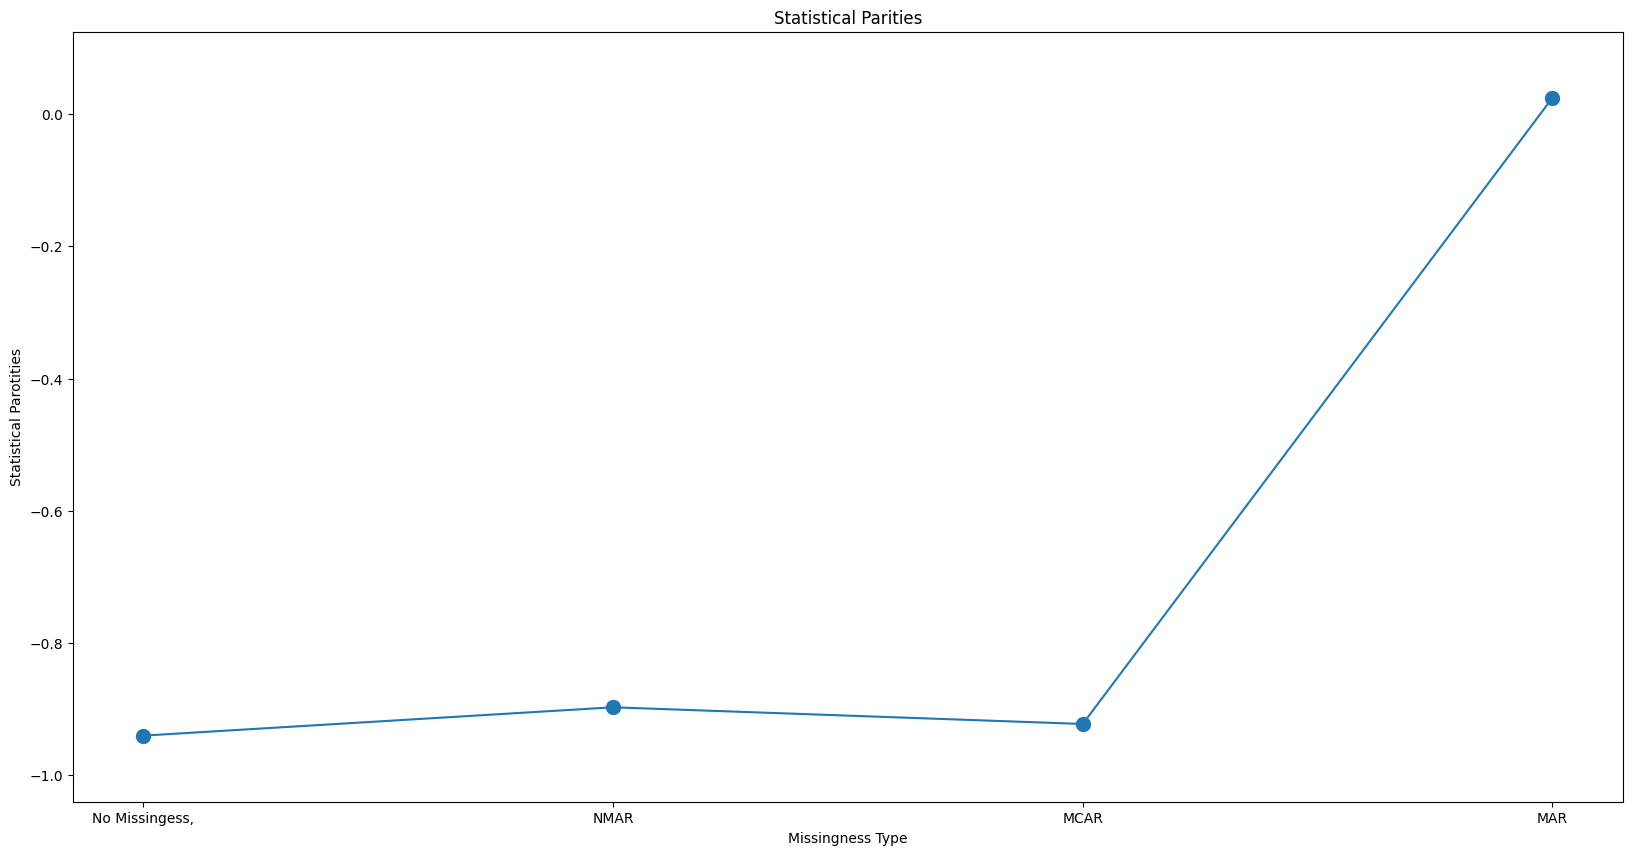

In [30]:
plt.figure(figsize = (20, 10))
plt.title('Statistical Parities')
plt.xlabel('Missingness Type')
plt.ylabel('Statistical Parotities')
plt.ylim(min(par) - 0.1, max(par) + 0.1)
plt.plot(labels, par, marker='.', markersize = 20)

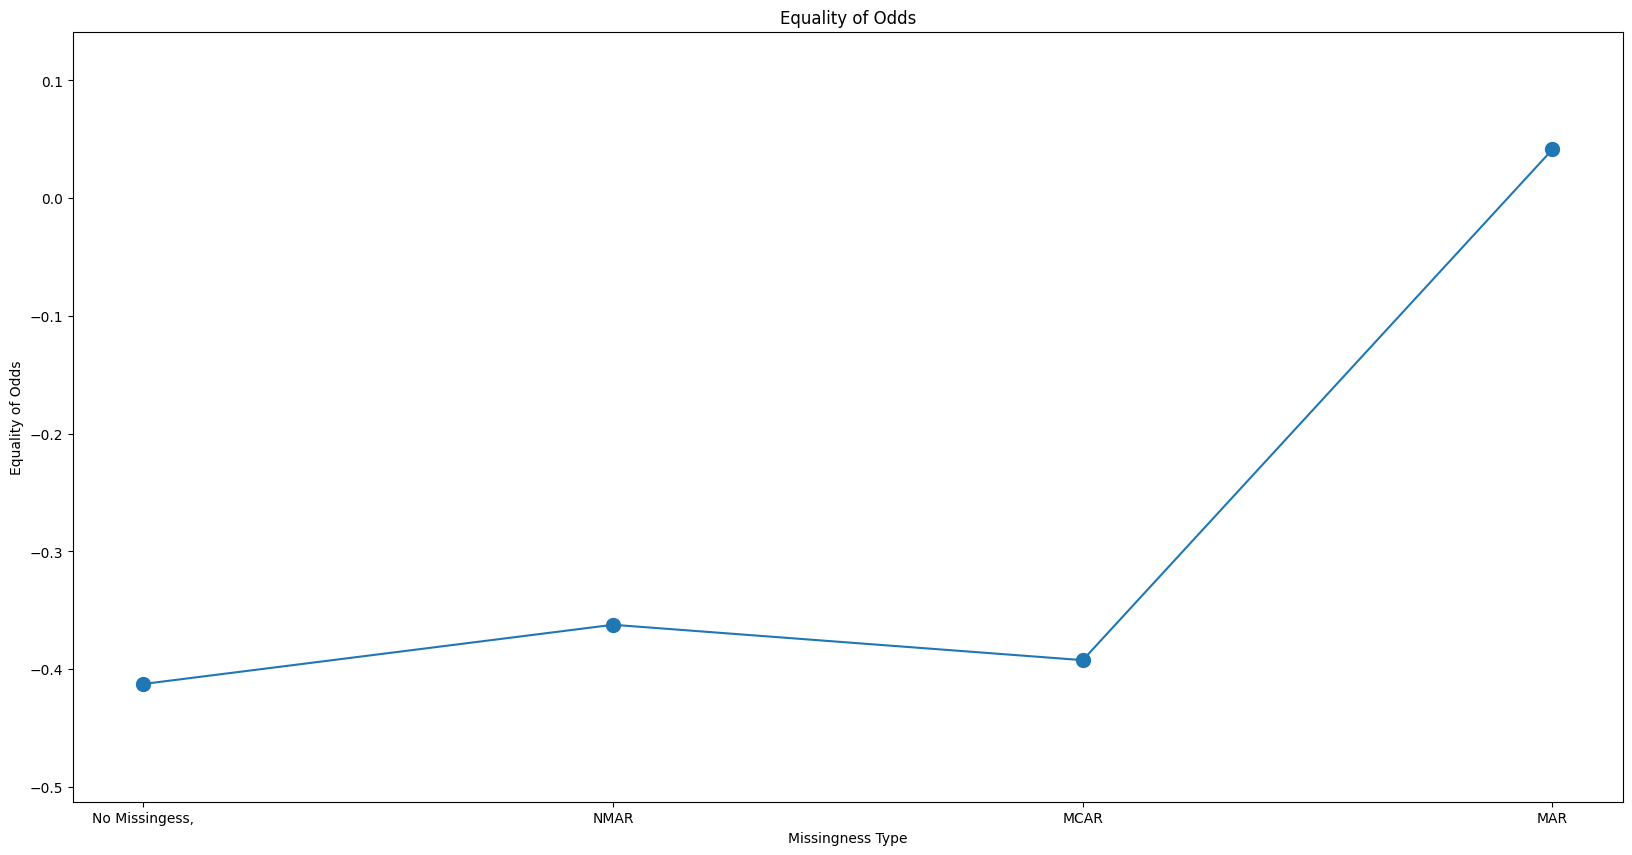

In [31]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Odds')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Odds')
plt.ylim(min(odds)-0.1,max(odds) + 0.1)
plt.plot(labels, odds, marker='.', markersize = 20)

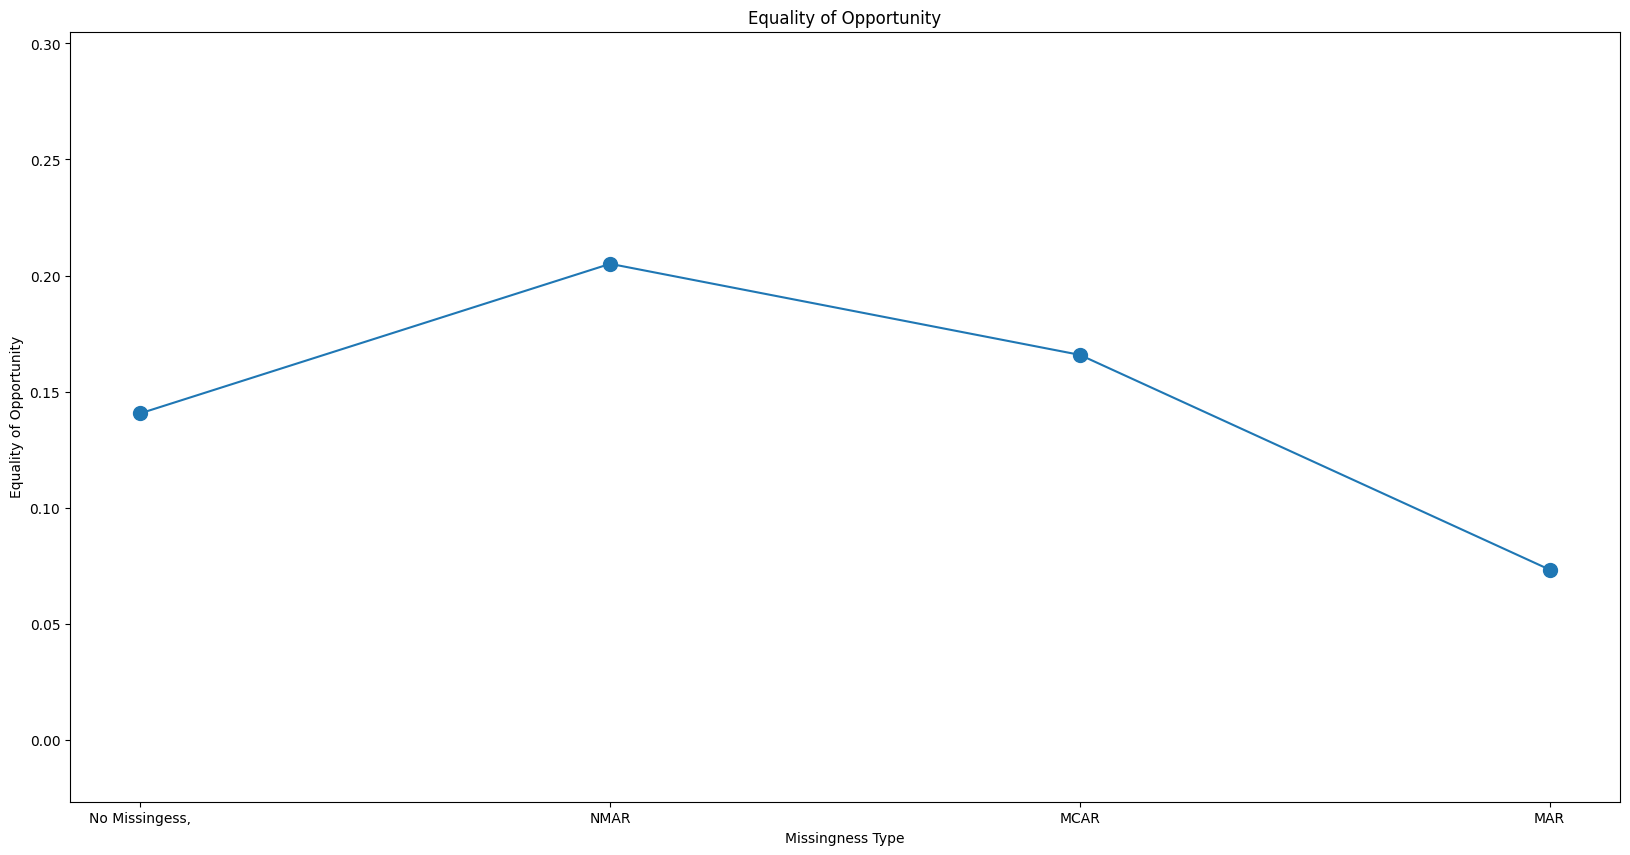

In [32]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Opportunity')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Opportunity')
plt.ylim(min(opp)-0.1,max(opp) + 0.1)
plt.plot(labels, opp, marker='.', markersize = 20)

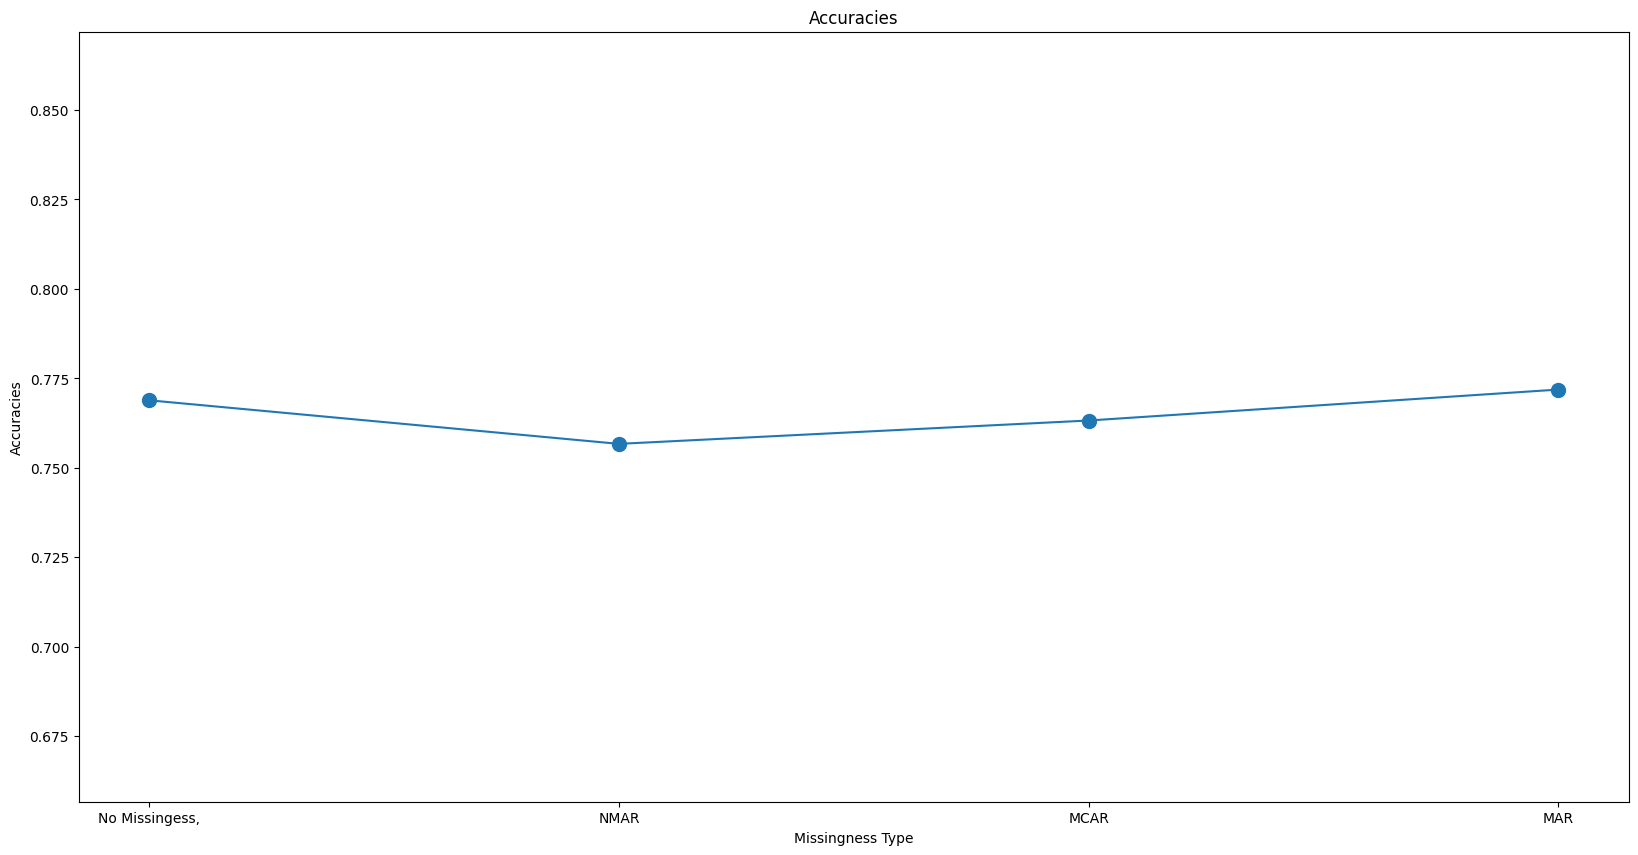

In [33]:
plt.figure(figsize = (20, 10))
plt.title('Accuracies')
plt.xlabel('Missingness Type')
plt.ylabel('Accuracies')
plt.ylim(min(acc)-0.1,max(acc) + 0.1)
plt.plot(labels, acc, marker='.', markersize = 20)